In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import dynamic_range_nms
from utils.set_seed import seed_base
from feature_engineering.stage2 import generate_2nd_stage_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ensemble"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ensemble']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-25 15:58:27.126306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 15:58:27.232987: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-25 15:58:28.256453: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_084


In [2]:
oof_2nd = pd.read_csv(f'/kaggle/output/{CFG["2nd_stage"]["execution"]["best_exp_id"]}/oof.csv')
oof_2nd.head()

,series_id,step,score,event
0,038441c925bb,4739,-0.005957,wakeup
1,038441c925bb,4739,1.777748,onset
2,038441c925bb,4763,-0.007765,wakeup
3,038441c925bb,4763,1.932611,onset
4,038441c925bb,4787,-0.005000,wakeup


In [3]:
oof_gru = pd.read_parquet(f'/kaggle/output/{CFG["patch_model"]["execution"]["best_exp_id"]}/oof.parquet')
oof_gru.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.001423,0.000193
1,05e1944c3818,18,0.001385,0.000224
2,05e1944c3818,30,0.001297,0.000247
3,05e1944c3818,42,0.001260,0.000309
4,05e1944c3818,54,0.001197,0.000346


In [4]:
wakeup_2nd = oof_2nd[oof_2nd["event"]=="wakeup"]
onset_2nd = oof_2nd[oof_2nd["event"]=="onset"]
dfs = []
for seires_id, df in tqdm(oof_gru.groupby("series_id")):
    df2 = oof_2nd[oof_2nd["series_id"]==seires_id]
    max_step = max(df["step"].max(), df2["step"].max())
    base = pd.DataFrame({"series_id": [seires_id]*max_step, "step": range(max_step)})
    df = base.merge(df, on=["series_id", "step"], how="left")
    df["onset_oof"] = df["onset_oof"].interpolate(method="linear", direction="both").fillna(0)
    df["wakeup_oof"] = df["wakeup_oof"].interpolate(method="linear", direction="both").fillna(0)

    df2 = wakeup_2nd[wakeup_2nd["series_id"]==seires_id]
    df["wakeup_oof_2nd"] = df["step"].map(df2.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    df2 = onset_2nd[onset_2nd["series_id"]==seires_id]
    df["onset_oof_2nd"] = df["step"].map(df2.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    df["wakeup_oof"] = df["wakeup_oof_2nd"] * 0.3 + df["wakeup_oof"] * 0.7
    df["onset_oof"] = df["onset_oof_2nd"] * 0.3 + df["onset_oof"] * 0.7
    df = df[["series_id", "step", "wakeup_oof", "onset_oof"]].reset_index(drop=True)
    dfs.append(df)
oof_df = pd.concat(dfs)
del dfs
gc.collect()

100%|██████████| 277/277 [01:49<00:00,  2.52it/s]


0

12413471

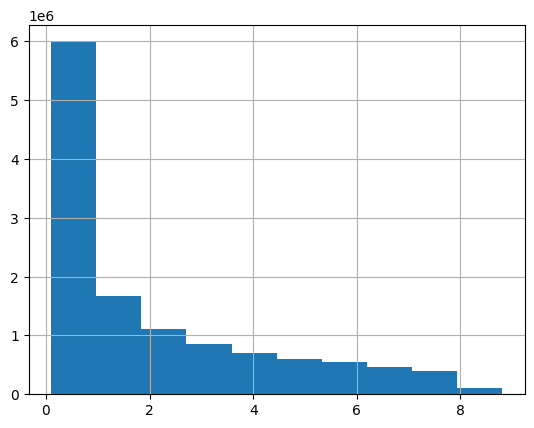

In [5]:
dfs = []
df = oof_df[["series_id", "step", "wakeup_oof"]]
df = df[df["wakeup_oof"] > 0.1]
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = oof_df[["series_id", "step", "onset_oof"]]
df = df[df["onset_oof"] > 0.1]
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs).reset_index(drop=True)
train["score"].hist()
len(train)

In [6]:
from multiprocessing import Pool

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:18<00:00, 15.22it/s]


In [7]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

score: 0.7888


event   tolerance
onset   12           0.256113
        36           0.661942
        60           0.778149
        90           0.824002
        120          0.858431
        150          0.873306
        180          0.888269
        240          0.902805
        300          0.910756
        360          0.917155
wakeup  12           0.322309
        36           0.678412
        60           0.772625
        90           0.813303
        120          0.845806
        150          0.861311
        180          0.880321
        240          0.898040
        300          0.911202
        360          0.921218
dtype: float64